# Fashion-MNIST – Convolutional Neural Networks

In this notebook we will:

1. Load the Fashion-MNIST dataset using helper functions from `utils.py`.
2. Define several CNN architectures in `cnn_model.py` (baseline, deeper, wider).
3. Train the models and track training/validation performance over epochs.
4. Evaluate the best models on the test set and inspect a normalised confusion matrix.

The goal is to understand how model architecture (depth and width) affects performance on Fashion-MNIST, while keeping the project structure simple:

- `utils.py` contains reusable training and evaluation utilities.
- `cnn_model.py` contains the CNN architectures.
- This notebook orchestrates the full experiment and visualisation.

## Imports and basic configuration

In this section we:

- Import PyTorch and other core libraries.
- Import our own helper functions from `utils.py` and the CNN models from `cnn_model.py`.
- Select the computation device (`cuda` if a GPU is available, otherwise `cpu`).
- Set a few basic hyperparameters (batch size, number of epochs, learning rate) that we can reuse later.

In [1]:
# Core imports
import torch
import torch.nn as nn

# Import our helper functions from utils.py
from utils import (
    get_dataloaders,
    train_model,
    evaluate_on_test,
    plot_training_history,
    plot_confusion_matrix,
)

# Import our CNN models from cnn_model.py
from cnn_model import (
    FashionMNISTCNN,
    FashionMNISTCNNDeeper,
    FashionMNISTCNNWider,
    count_parameters,
)

# Select device: use GPU (cuda) if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Basic hyperparameters for the experiments
batch_size = 64       # How many images per batch
num_epochs = 10       # How many passes over the training set
learning_rate = 1e-3  # Step size for the optimiser
weight_decay = 1e-4   # L2 regularisation strength


Using device: cpu


## Class names for Fashion-MNIST

Fashion-MNIST has 10 classes. We define their human-readable names here so we can
use them later when plotting the confusion matrix and inspecting results.

In [2]:
# Human-readable names for the 10 Fashion-MNIST classes
fashion_classes = [
    "T-shirt/Top",  # 0
    "Trouser",      # 1
    "Pullover",     # 2
    "Dress",        # 3
    "Coat",         # 4
    "Sandal",       # 5
    "Shirt",        # 6
    "Sneaker",      # 7
    "Bag",          # 8
    "Ankle Boot",   # 9
]

len(fashion_classes), fashion_classes

(10,
 ['T-shirt/Top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle Boot'])

## Loading the Fashion-MNIST data

In this section we:

- Use the `get_dataloaders` function from `utils.py` to download and prepare the Fashion-MNIST dataset.
- Obtain three `DataLoader` objects:
  - `train_loader` for training,
  - `val_loader` for validation,
  - `test_loader` for final evaluation.
- Quickly inspect the number of samples in each split and the shape of one batch.

The `get_dataloaders` function:
- Applies data augmentation (random flips/rotations) only to the training set.
- Normalises images to have mean 0.5 and standard deviation 0.5.
- Splits the original training set into training and validation subsets.

In [3]:
# Load DataLoaders for training, validation, and test sets
train_loader, val_loader, test_loader = get_dataloaders(batch_size=batch_size)

# Check how many samples we have in each split
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

# Inspect a single batch to verify shapes
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)  # Expected: (batch_size, 1, 28, 28)
print("Batch labels tensor shape:", labels.shape) # Expected: (batch_size,)

Train samples: 54000
Validation samples: 6000
Test samples: 10000
Batch image tensor shape: torch.Size([64, 1, 28, 28])
Batch labels tensor shape: torch.Size([64])


## Baseline CNN model

We start with the baseline CNN defined in `cnn_model.py`:

- Three convolutional blocks with batch normalisation, ReLU, max-pooling and dropout.
- A small fully connected classifier on top.

In this section we:

- Create an instance of `FashionMNISTCNN`.
- Move it to the selected device (`cuda` or `cpu`).
- Print how many trainable parameters it has, to get a sense of its size.

In [4]:
# Create an instance of the baseline CNN
baseline_model = FashionMNISTCNN(num_classes=10)

# Move the model to the selected device (GPU or CPU)
baseline_model.to(device)

# Print the number of trainable parameters
n_params = count_parameters(baseline_model)
print(baseline_model)
print(f"\nNumber of trainable parameters (baseline): {n_params:,}")

FashionMNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Number of trainable parameters (baseline): 390,858


### Training the baseline CNN

In this section we train the baseline CNN using:

- The `train_model` function from `utils.py`.
- Cross-entropy loss (the default inside `train_model` when no custom criterion is passed).
- The Adam optimiser with the learning rate and weight decay we defined earlier.

What happens during training:

1. For each epoch:
   - The model runs in training mode on the training set.
   - We accumulate the training loss and accuracy.
2. After each epoch:
   - The model is evaluated on the validation set.
   - Validation loss and accuracy are recorded.
3. The function keeps track of the **best** validation accuracy and stores those model weights.
4. At the end, the model is restored to the best version and the training history is returned.

In [5]:
# Train the baseline model
print("Training baseline CNN...")

baseline_model, baseline_history = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay
)

print("\nTraining complete.")

Training baseline CNN...
Epoch 01: Train Loss=0.6761, Acc=0.7536 | Val Loss=0.4061, Acc=0.8473
Epoch 02: Train Loss=0.4752, Acc=0.8264 | Val Loss=0.3506, Acc=0.8692
Epoch 03: Train Loss=0.4235, Acc=0.8466 | Val Loss=0.3253, Acc=0.8785
Epoch 04: Train Loss=0.4010, Acc=0.8545 | Val Loss=0.3039, Acc=0.8863
Epoch 05: Train Loss=0.3782, Acc=0.8625 | Val Loss=0.2907, Acc=0.8928
Epoch 06: Train Loss=0.3664, Acc=0.8666 | Val Loss=0.2756, Acc=0.8975
Epoch 07: Train Loss=0.3522, Acc=0.8719 | Val Loss=0.2752, Acc=0.8973
Epoch 08: Train Loss=0.3399, Acc=0.8770 | Val Loss=0.2631, Acc=0.9032
Epoch 09: Train Loss=0.3355, Acc=0.8774 | Val Loss=0.2586, Acc=0.9047
Epoch 10: Train Loss=0.3261, Acc=0.8824 | Val Loss=0.2544, Acc=0.9057

Training complete.


### Training and validation curves (baseline CNN)

Now that the baseline CNN has been trained, we can inspect how:

- The **training loss** and **validation loss** evolved over epochs.
- The **training accuracy** and **validation accuracy** changed over time.

This helps us to see if the model is:

- Underfitting (both losses high, accuracies low),
- Overfitting (training loss very low, validation loss increasing),
- Or learning in a stable way (both improving and then flattening).


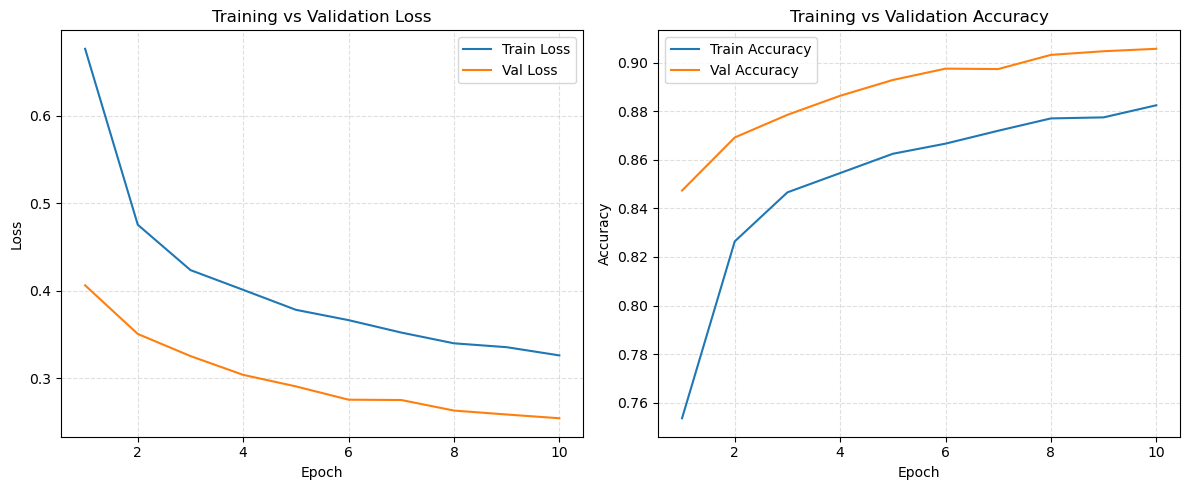

In [6]:
# Plot training vs validation loss and accuracy for the baseline model
plot_training_history(baseline_history)

### Test set evaluation (baseline CNN)

After training and choosing the best version of the baseline CNN (based on validation accuracy),
we now evaluate it on the **test set**.

This gives us:

- An unbiased estimate of how well the model generalises.
- Overall test loss and accuracy.
- The full set of predictions and ground-truth labels, which we can later use to:
  - Plot a normalised confusion matrix.
  - Inspect which classes are more difficult.

In [7]:
# Evaluate the trained baseline model on the test set
print("Evaluating baseline CNN on the test set...")

baseline_test_loss, baseline_test_acc, baseline_y_true, baseline_y_pred = evaluate_on_test(
    model=baseline_model,
    test_loader=test_loader,
    device=device,
    print_report=True   # This will print a classification report and the raw confusion matrix
)

print(f"\nBaseline test loss: {baseline_test_loss:.4f}")
print(f"Baseline test accuracy: {baseline_test_acc:.4f}")

Evaluating baseline CNN on the test set...

Test Loss: 0.2637, Accuracy: 0.9040

Classification Report:
              precision    recall  f1-score   support

           0     0.8197    0.8910    0.8539      1000
           1     0.9949    0.9790    0.9869      1000
           2     0.8332    0.8890    0.8602      1000
           3     0.8926    0.9140    0.9032      1000
           4     0.8165    0.8720    0.8433      1000
           5     0.9828    0.9710    0.9769      1000
           6     0.8008    0.6230    0.7008      1000
           7     0.9391    0.9710    0.9548      1000
           8     0.9908    0.9720    0.9813      1000
           9     0.9687    0.9580    0.9633      1000

    accuracy                         0.9040     10000
   macro avg     0.9039    0.9040    0.9024     10000
weighted avg     0.9039    0.9040    0.9024     10000

Confusion Matrix:
[[891   0  14  20   7   1  64   0   3   0]
 [  0 979   0  16   2   0   1   0   2   0]
 [ 16   0 889  11  51   0  33   0

### Normalised confusion matrix (baseline CNN)

To better understand *which* classes the baseline CNN predicts correctly or incorrectly,
we plot a **normalised confusion matrix**:

- Each row corresponds to the **true** class.
- Each column corresponds to the **predicted** class.
- Values are normalised per row (in percent), so each row sums to 100%.

This makes it easy to see, for example:

- Whether `Shirt` is often confused with `T-shirt/Top` or `Pullover`.
- Whether some classes (like `Bag` or `Ankle Boot`) are much easier than others.


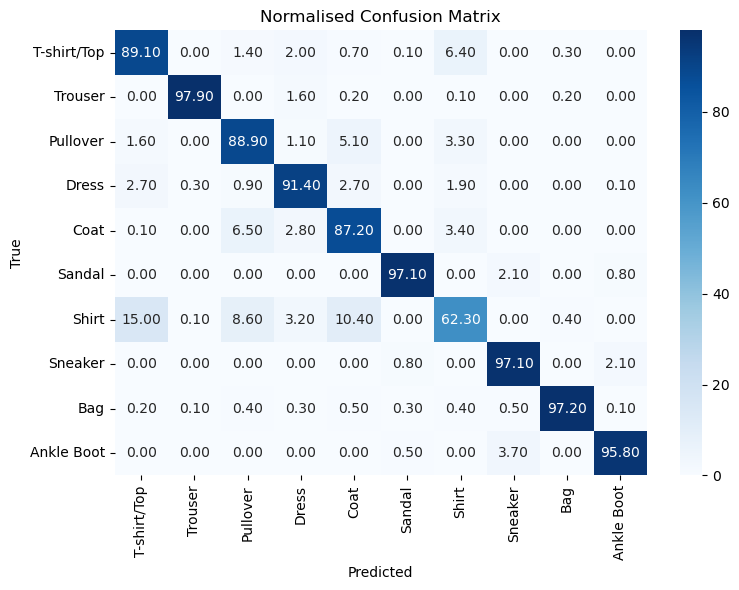

In [8]:
# Plot a normalised confusion matrix for the baseline model
plot_confusion_matrix(
    y_true=baseline_y_true,
    y_pred=baseline_y_pred,
    class_names=fashion_classes,
    normalise=True
)

## Deeper CNN model

Now we repeat the same workflow using a **deeper** CNN architecture:
`FashionMNISTCNNDeeper` from `cnn_model.py`.

This model has:

- The same channel sizes as the baseline (32, 64, 128),
- But **two convolutional layers per block** before each max-pooling operation.

The idea is to increase **depth** (more layers) while keeping the overall structure
and number of channels similar, so we can see how depth alone affects performance.

In [9]:
# Create an instance of the deeper CNN
deeper_model = FashionMNISTCNNDeeper(num_classes=10)

# Move the model to the selected device (GPU or CPU)
deeper_model.to(device)

# Print the architecture and number of parameters
deeper_params = count_parameters(deeper_model)
print(deeper_model)
print(f"\nNumber of trainable parameters (deeper): {deeper_params:,}")

FashionMNISTCNNDeeper(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3_2): BatchNorm2d(128, eps=1e-05, moment

### Training the deeper CNN

We now train the `FashionMNISTCNNDeeper` model using the same setup:

- Same training and validation data.
- Same number of epochs, learning rate and weight decay.
- Same training loop (`train_model` from `utils.py`),
  still using standard cross-entropy loss.

This allows us to compare the deeper model fairly against the baseline.


In [10]:
# Train the baseline model
print("Training deeper CNN...")

deeper_model, deeper_history = train_model(
    model=deeper_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay
)

print("\nTraining complete (deeper model).")

Training deeper CNN...
Epoch 01: Train Loss=0.5978, Acc=0.7797 | Val Loss=0.3591, Acc=0.8678
Epoch 02: Train Loss=0.3997, Acc=0.8545 | Val Loss=0.3023, Acc=0.8852
Epoch 03: Train Loss=0.3522, Acc=0.8722 | Val Loss=0.2908, Acc=0.8965
Epoch 04: Train Loss=0.3274, Acc=0.8814 | Val Loss=0.2586, Acc=0.9040
Epoch 05: Train Loss=0.3118, Acc=0.8871 | Val Loss=0.2472, Acc=0.9125
Epoch 06: Train Loss=0.3005, Acc=0.8926 | Val Loss=0.2491, Acc=0.9107
Epoch 07: Train Loss=0.2870, Acc=0.8965 | Val Loss=0.2423, Acc=0.9125
Epoch 08: Train Loss=0.2790, Acc=0.9007 | Val Loss=0.2290, Acc=0.9182
Epoch 09: Train Loss=0.2746, Acc=0.9016 | Val Loss=0.2228, Acc=0.9177
Epoch 10: Train Loss=0.2670, Acc=0.9029 | Val Loss=0.2334, Acc=0.9165

Training complete (deeper model).


### Training and validation curves (deeper CNN)

We now visualise how the deeper CNN trained over time.

By comparing these curves with the baseline plots, we can see whether:

- The deeper model converges faster or slower,
- It overfits more or less,
- It reaches higher or lower validation accuracy.


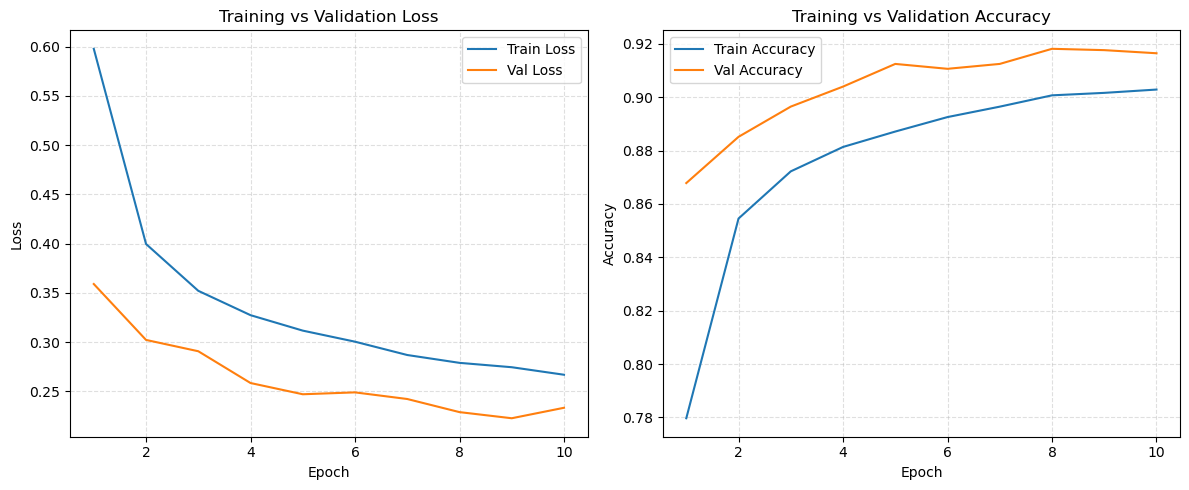

In [11]:
# Plot training vs validation loss and accuracy for the deeper model
plot_training_history(deeper_history)

### Test set evaluation (deeper CNN)

Next, we evaluate the trained deeper CNN on the **test set**.

We obtain:

- Test loss and test accuracy,
- A full classification report (precision, recall, F1 per class),
- A raw confusion matrix (counts),
- And we store predictions and true labels for plotting a normalised confusion matrix.

In [12]:
# Evaluate the trained baseline model on the test set
print("Evaluating deeper CNN on the test set...")

deeper_test_loss, deeper_test_acc, deeper_y_true, deeper_y_pred = evaluate_on_test(
    model=deeper_model,
    test_loader=test_loader,
    device=device,
    print_report=True   # This will print a classification report and the raw confusion matrix
)

print(f"\nDeeper test loss: {deeper_test_loss:.4f}")
print(f"Deeper test accuracy: {deeper_test_acc:.4f}")

Evaluating deeper CNN on the test set...

Test Loss: 0.2401, Accuracy: 0.9143

Classification Report:
              precision    recall  f1-score   support

           0     0.8222    0.9110    0.8643      1000
           1     0.9929    0.9830    0.9879      1000
           2     0.8933    0.8620    0.8774      1000
           3     0.9280    0.9150    0.9215      1000
           4     0.8124    0.9310    0.8677      1000
           5     0.9918    0.9620    0.9766      1000
           6     0.8184    0.6670    0.7350      1000
           7     0.9258    0.9860    0.9550      1000
           8     0.9909    0.9750    0.9829      1000
           9     0.9794    0.9510    0.9650      1000

    accuracy                         0.9143     10000
   macro avg     0.9155    0.9143    0.9133     10000
weighted avg     0.9155    0.9143    0.9133     10000

Confusion Matrix:
[[911   0  18  13   5   1  46   0   6   0]
 [  0 983   0  12   2   0   2   0   1   0]
 [ 17   1 862   9  82   0  29   0  

### Normalised confusion matrix (deeper CNN)

Finally, we plot a **normalised confusion matrix** for the deeper CNN, using
the same class names as before.

This lets us compare, class by class, how the deeper model behaves relative to
the baseline:

- Does it reduce confusion between specific pairs of classes?
- Does it improve performance on the more difficult categories?


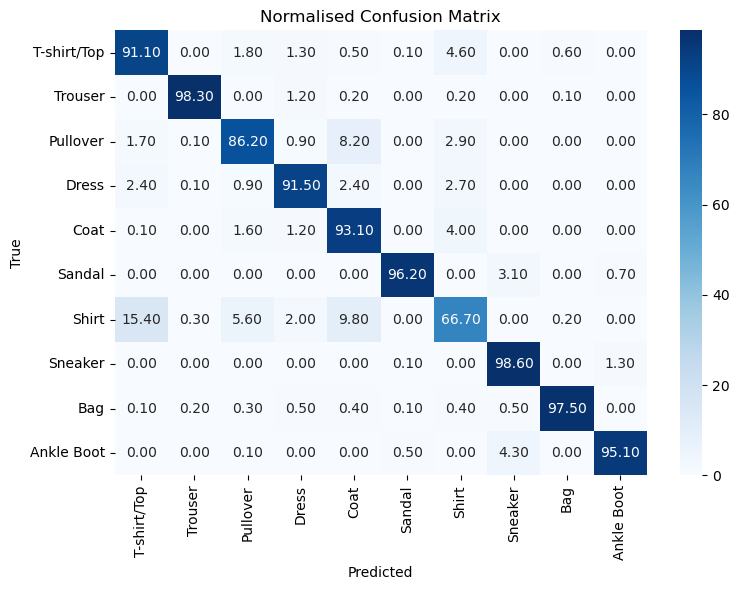

In [13]:
# Plot a normalised confusion matrix for the deeper model
plot_confusion_matrix(
    y_true=deeper_y_true,
    y_pred=deeper_y_pred,
    class_names=fashion_classes,
    normalise=True
)

## Wider CNN model

Now we repeat the workflow using a **wider** CNN architecture:
`FashionMNISTCNNWider` from `cnn_model.py`.

This model:

- Has the same overall structure as the baseline (three convolutional blocks),
- But uses **more channels** in each block (e.g. 64, 128, 256 instead of 32, 64, 128).

The idea is to increase **width** (more feature maps per layer) so the network can
capture more diverse features at each stage, and then compare this with the
baseline and deeper architectures.

In [14]:
# Create an instance of the wider CNN
wider_model = FashionMNISTCNNWider(num_classes=10)

# Move the model to the selected device (GPU or CPU)
wider_model.to(device)

# Print the architecture and number of trainable parameters
wider_params = count_parameters(wider_model)
print(wider_model)
print(f"\nNumber of trainable parameters (wider): {wider_params:,}")

FashionMNISTCNNWider(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Number of trainable parameters (wider): 963,210


### Training the wider CNN

We now train the `FashionMNISTCNNWider` model using the **same setup**:

- Same train/validation splits.
- Same number of epochs, learning rate and weight decay.
- Same training loop (`train_model` from `utils.py`).

This keeps the comparison fair: any performance difference should mainly come
from the architecture (wider vs deeper vs baseline), not from different
training conditions.


In [15]:
print("Training wider CNN...")

wider_model, wider_history = train_model(
    model=wider_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay,
)

print("\nTraining complete (wider model).")

Training wider CNN...
Epoch 01: Train Loss=0.6387, Acc=0.7684 | Val Loss=0.3945, Acc=0.8480
Epoch 02: Train Loss=0.4526, Acc=0.8358 | Val Loss=0.3236, Acc=0.8745
Epoch 03: Train Loss=0.4033, Acc=0.8541 | Val Loss=0.3047, Acc=0.8890
Epoch 04: Train Loss=0.3711, Acc=0.8681 | Val Loss=0.2848, Acc=0.8953
Epoch 05: Train Loss=0.3525, Acc=0.8733 | Val Loss=0.2823, Acc=0.8972
Epoch 06: Train Loss=0.3382, Acc=0.8783 | Val Loss=0.2594, Acc=0.9022
Epoch 07: Train Loss=0.3311, Acc=0.8796 | Val Loss=0.2550, Acc=0.9058
Epoch 08: Train Loss=0.3169, Acc=0.8850 | Val Loss=0.2565, Acc=0.8998
Epoch 09: Train Loss=0.3121, Acc=0.8867 | Val Loss=0.2446, Acc=0.9122
Epoch 10: Train Loss=0.3069, Acc=0.8898 | Val Loss=0.2554, Acc=0.9053

Training complete (wider model).


### Training and validation curves (wider CNN)

We now plot the training and validation curves for the wider model.

By comparing these curves with those of the baseline and deeper CNNs we can see:

- Whether the wider model learns faster or slower,
- Whether it overfits more (e.g. very low training loss but worse validation loss),
- Whether it reaches a higher or lower validation accuracy.

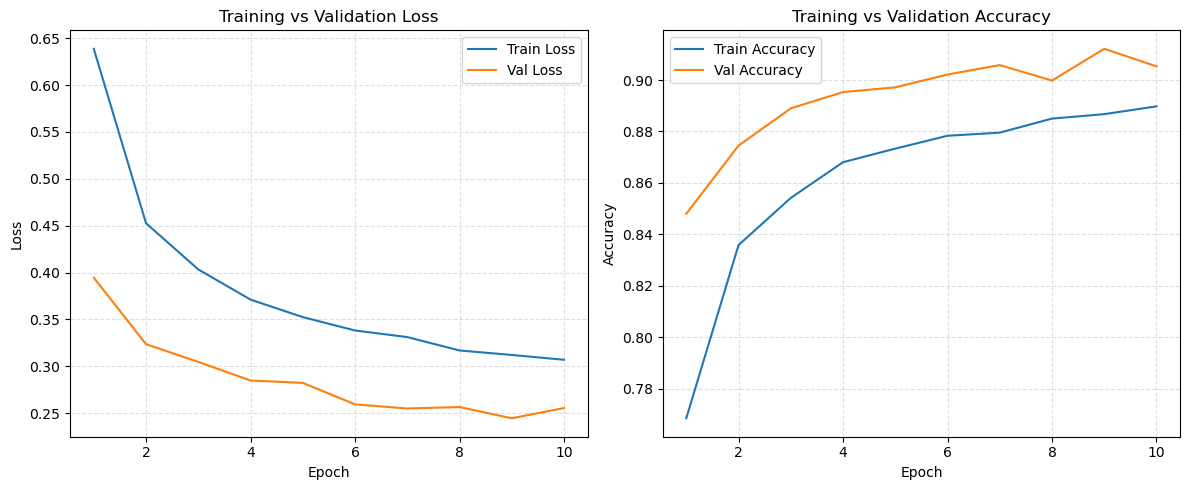

In [16]:
# Plot training vs validation loss and accuracy for the wider model
plot_training_history(wider_history)

### Test set evaluation (wider CNN)

Next, we evaluate the trained wider CNN on the **test set**.

We obtain:

- Test loss and test accuracy,
- A classification report (precision, recall, F1 for each class),
- A raw confusion matrix,
- Predictions and true labels for plotting a normalised confusion matrix.

In [17]:
print("Evaluating wider CNN on the test set...")

wider_test_loss, wider_test_acc, wider_y_true, wider_y_pred = evaluate_on_test(
    model=wider_model,
    test_loader=test_loader,
    device=device,
    print_report=True
)

print(f"\nWider model test loss: {wider_test_loss:.4f}")
print(f"Wider model test accuracy: {wider_test_acc:.4f}")

Evaluating wider CNN on the test set...

Test Loss: 0.2577, Accuracy: 0.9047

Classification Report:
              precision    recall  f1-score   support

           0     0.8555    0.8700    0.8627      1000
           1     0.9990    0.9720    0.9853      1000
           2     0.8867    0.8450    0.8653      1000
           3     0.9041    0.8960    0.9001      1000
           4     0.8426    0.8460    0.8443      1000
           5     0.9907    0.9630    0.9767      1000
           6     0.7018    0.7530    0.7265      1000
           7     0.9199    0.9880    0.9527      1000
           8     0.9888    0.9720    0.9803      1000
           9     0.9812    0.9420    0.9612      1000

    accuracy                         0.9047     10000
   macro avg     0.9070    0.9047    0.9055     10000
weighted avg     0.9070    0.9047    0.9055     10000

Confusion Matrix:
[[870   0   8  12   2   1 102   0   5   0]
 [  0 972   1  20   2   0   3   0   2   0]
 [ 15   0 845  11  60   0  69   0   

### Normalised confusion matrix (wider CNN)

Finally, we plot the **normalised confusion matrix** for the wider CNN.

This allows us to compare its behaviour to the baseline and deeper models:

- Does increased width reduce confusion between particular pairs of classes?
- Does it help more with certain categories (e.g. `Shirt` vs `T-shirt/Top`)?

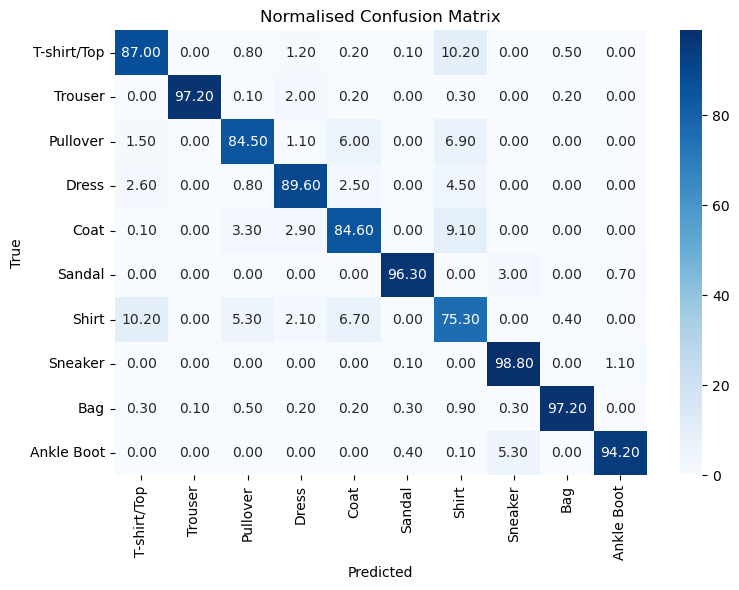

In [18]:
plot_confusion_matrix(
    y_true=wider_y_true,
    y_pred=wider_y_pred,
    class_names=fashion_classes,
    normalise=True
)

## Model comparison summary

We have now trained and evaluated three CNN architectures:

- **Baseline CNN**: `FashionMNISTCNN`
- **Deeper CNN**: `FashionMNISTCNNDeeper`
- **Wider CNN**: `FashionMNISTCNNWider`

In this section we summarise their:

- Number of trainable parameters,
- Test accuracy on the Fashion-MNIST test set.

This gives a compact view of the trade-offs between model size (capacity) and performance.

In [20]:
import pandas as pd

# Recompute parameter counts in case the earlier variables are not in scope
baseline_params = count_parameters(baseline_model)
deeper_params = count_parameters(deeper_model)
wider_params = count_parameters(wider_model)

# Build a small summary table
summary_rows = [
    {
        "Model": "Baseline CNN",
        "Architecture": "FashionMNISTCNN",
        "Parameters": baseline_params,
        "Test Accuracy": baseline_test_acc,
    },
    {
        "Model": "Deeper CNN",
        "Architecture": "FashionMNISTCNNDeeper",
        "Parameters": deeper_params,
        "Test Accuracy": deeper_test_acc,
    },
    {
        "Model": "Wider CNN",
        "Architecture": "FashionMNISTCNNWider",
        "Parameters": wider_params,
        "Test Accuracy": wider_test_acc,
    },
]

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

          Model           Architecture  Parameters  Test Accuracy
0  Baseline CNN        FashionMNISTCNN      390858         0.9040
1    Deeper CNN  FashionMNISTCNNDeeper      585066         0.9143
2     Wider CNN   FashionMNISTCNNWider      963210         0.9047


## Interpretation and Discussion

### 1. Overall Performance Comparison

The three architectures achieve the following test accuracies:

- **Baseline CNN:** 0.9040  
- **Deeper CNN:** 0.9143  
- **Wider CNN:** 0.9047  

Despite having fewer parameters than the wider model, the **deeper architecture performs best**. This indicates that increasing **depth** (more convolutional layers per block) improves feature extraction more effectively than simply adding more channels.

Parameter counts provide further context:

- Baseline: **390,858**  
- Deeper: **585,066**  
- Wider: **963,210**

The deeper model is moderately larger than the baseline but significantly smaller than the wider model. Yet it achieves the best performance, suggesting that **hierarchical depth** is a more efficient form of capacity increase for Fashion-MNIST than width.

---

### 2. Per-Class Performance Highlights

#### The deeper model shows consistent improvements across several classes:

- **Class 4 (Coat):**  
  - Baseline recall: **0.872**  
  - Deeper recall: **0.931**  
  - Wider recall: **0.846**  
  The deeper model substantially reduces misclassifications for “Coat”.

- **Class 6 (Shirt):**  
  The most difficult category for all models:  
  - Baseline recall: **0.623**  
  - Deeper recall: **0.667**  
  - Wider recall: **0.753**

  Here, the wider model performs best, indicating that additional channels may help capture the greater variability within the “Shirt” category.

- **Easy classes:**  
  For “Trouser”, “Sandal”, “Bag” and “Ankle Boot”, all models achieve very high recall (>0.95). These categories have distinct shapes, making them easier to classify.

Overall, the deeper CNN shows the **most balanced improvements**, while the wider CNN shows **localised strength** in specific categories.

---

### 3. Confusion Matrix Patterns

#### Baseline CNN
- Strong confusion between **Shirt (6)** and **T-shirt/Top (0)** (150 misclassifications).
- Notable confusion between **Pullover (2)** and **Coat (4)**.
- Very good performance on **Bag (8)** and **Ankle Boot (9)**.

#### Deeper CNN
- Improves recall for many classes, especially **Coat (4)**.  
- Shows slightly reduced confusion in several clothing categories, producing a cleaner diagonal.  
- Some misclassifications (e.g. Pullover ↔ Coat) increase, which suggests deeper models may pick up subtler texture similarities.

#### Wider CNN
- Shows the **best improvement** for **Shirt (6)**, the hardest class.  
- However, introduces more confusion among other mid-range clothing classes (e.g. Pullover ↔ Coat).  
- Demonstrates good performance on easy categories but less balanced improvements overall.

#### Confusion Matrix Summary
- **Deeper CNN:** Most balanced improvements; cleaner diagonal; fewer systematic errors.  
- **Wider CNN:** Strong for highly variable classes but introduces new confusions elsewhere.  
- **Baseline CNN:** Solid performer but weaker in ambiguous clothing categories.

---

### 4. Architectural Implications

- **Depth is more effective than width** for Fashion-MNIST.  
  The deeper model generalises better despite having fewer parameters than the wider model.

- **Width helps with difficult, high-variability classes** like Shirt.  
  More channels may capture a wider variety of textures.

- **Most errors occur between visually similar categories**, such as Shirt, T-shirt/Top and Pullover.

---

### 5. Final Conclusion

Among the three architectures:

- The **deeper CNN** provides the strongest overall performance, both quantitatively (highest test accuracy) and qualitatively (cleaner confusion matrix).
- The **wider CNN** excels in specific areas—especially class 6 (Shirt)—but trades off performance in other clothing categories.
- The **baseline CNN** is a solid reference point, but increasing depth clearly leads to more effective feature extraction.

A potential future direction would be to explore a hybrid model that is **both deeper and slightly wider**, combining the strengths observed in both directions.

